In [7]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using LinearAlgebra
using DifferentialEquations
using Turing
include("./../GrowthTraceTools.jl")
using .GrowthTraceTools

## Load experimental data (Gaussian process output)

In [8]:

df_all = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

In [9]:
preds = []
params = []
pred_dir = "./../output/output_8-27-24"
files = readdir(pred_dir)
for f in files
    df = CSV.read(pred_dir*"/"*f*"/preds.csv",DataFrame)
    ag(t) = round.(t .- t[1],digits=2)
    df = combine(groupby(df,:position),:time => ag => :age,names(df))
    push!(preds,df)
    #push!(params,CSV.read(pred_dir*"/"*f*"/opt_params.csv",DataFrame))
end

lineages = [parse(Int64,split(f,"_")[2]) for f in files]

7-element Vector{Int64}:
  1
 14
  2
 22
  4
  5
  6

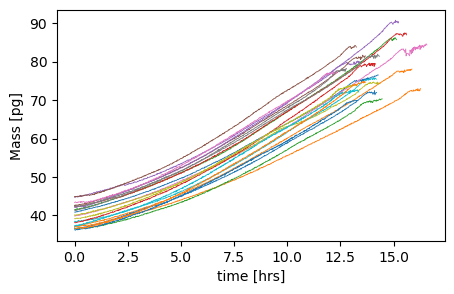

In [22]:
k = 6
data = preds[k]
data_raw = df_all[df_all.lineage .== lineages[k],:]

fig,ax = subplots(figsize=(5,3))
for p in unique(data_raw.position)
    t = data_raw[data_raw.position .== p,:].time
    M = data_raw[data_raw.position .==p,:].M
    a = cov(M,t)/var(t)
    z = M  .- a .* t
    z = z .- mean(z)
    ax.plot(t .- t[1],M,lw=0.6)
end
ax.set_xlabel("time [hrs]")
ax.set_ylabel("Mass [pg]")
fig

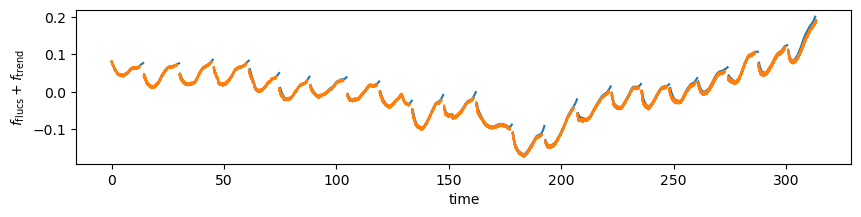

In [277]:

positions = unique(data.position)
fig,ax = subplots(figsize=(10,2),sharey=true)

slope = cov(data_raw[:,:lnM_sum],data_raw[:,:time])/var(data_raw[:,:time])
inter = mean(data_raw[:,:lnM_sum]) - slope*mean(data_raw[:,:time])
y_pred = slope*data_raw[:,:time] .+ inter
data_raw.time = data_raw.time .- data_raw.time[1]
data_raw[:,:y]= data_raw[:,:lnM_sum] .- y_pred
data_raw = data_raw[data_raw.cellcycle .== "i",:]

for i in eachindex(positions)
    p = positions[i]
    d= data[data.position .== p,:]
    dr = data_raw[data_raw.position .== p,:]
    ax.plot(d.time,d.matern32_flucs+ d.matern32_cell,"C0")
    ax.plot(dr.time,dr.y,"C1")
end

#ax.fill_between(data.time,data.matern32_flucs .+ data.matern32_cell  .- v,data.matern32_flucs .+  data.matern32_cell .+	v,alpha=.1)



#ax.plot(data_raw.time .- data_raw.time[1],y,label="data")
ax.legend(frameon=false)
ax.set_xlabel("time")
ax.set_ylabel(L"$f_{\rm flucs} + f_{\rm trend}$")

fig

In [278]:
DataFrame(params=[1,3,3])

Row,params
,Int64
1,1
2,3
3,3


## Testing making experimental data for loss function (WIP)

In [25]:
# parameter values
λ0 = 0.05
init = [40,λ0,80,0]
σ_gr = sqrt(1.32e-4)
τ = 1
D = σ_gr^2/τ
σDS = 0.0005
Δ = 40
σM = sqrt(50)

7.0710678118654755

In [26]:
df_data = preds[2]; # we will work with one lineage at a time
dt_data = mean(diff(df_data.time))

θ = [Δ,σDS,τ,λ0,D,σM] 
prob,callback,vars = build_model_OU(θ,init,(0,400))
@time sol = solve(prob,callback = callback,saveat=df_data.time,adaptive =true,dt=0.0001)
u = hcat(sol.u...)';

u

  2.262741 seconds (6.83 M allocations: 359.508 MiB, 3.60% gc time, 97.56% compilation time)


524×4 adjoint(::Matrix{Float64}) with eltype Float64:
 40.0      0.05        80.0     0.0
 42.5347   0.0147246   80.0     0.0
 41.15    -0.126982    80.0     0.0
 41.3695   0.0567929   80.0     0.0
 44.1262   0.373689    80.0     0.0
 55.7706   0.387697    80.0     0.0
 62.0055   0.199163    80.0     0.0
 66.2932   0.198055    80.0     0.0
 66.659    0.139685    80.0     0.0
 70.717   -0.068429    80.0     0.0
  ⋮                             
 33.2913   0.0507268   78.2814  8.0
 34.8366   0.195047    78.2814  8.0
 36.435    0.0708464   78.2814  8.0
 35.0918  -0.134962    78.2814  8.0
 32.7388  -0.0949785   78.2814  8.0
 32.347    0.00440626  78.2814  8.0
 34.6626   0.233554    78.2814  8.0
 78.2814   0.219687    78.2814  8.0
 39.1407   0.219856    85.9754  9.0

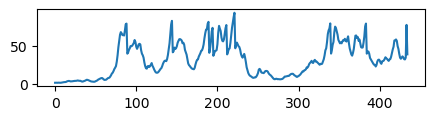

In [28]:
fig, ax= subplots(figsize=(5,1))
ax.plot(u[90:end,1],"-")
fig

# MSD Analysis setup

In [188]:
function msd_withinbetween(u,lag)
    """
    Takes as input an array whose first column is 
    the growth rates and second is the position
    returns MSD within and between
    """
    δ = (u[1:end-lag,1] .- u[lag:end-1,1]).^2
    is_within = (u[1:end-lag,2] .== u[lag+1:end,2])
    δ_within = δ[is_within .== 1]
    δ_between = δ[is_within .== 0]
    return [mean(δ_within),mean(δ_between)]
end


function msd_lineage(df,x,lag)
    x_data = Array(df[:,[x,:position]]);
    M = hcat([msd_withinbetween(x_data,l) for l in 1:1:50]...)'
end 


function msd_lineage_ratio_avg(df,x,lag)
    M = msd_lineage(df,x,lag)
    mw = M[:,1]
    mb = M[:,2]
    r = mw ./ (mb .+ mw)
    mean(filter(!isnan,r))
end

function msd_lineage_avg_ratio(df,x,lag)
    M = msd_lineage(df,x,lag)
    mw =filter(!isnan,M[:,1])
    mb = filter(!isnan,M[:,2])
    r = mean(mw) ./ (mean(mb) .+ mean(mw))
end 

msd_lineage_avg_ratio (generic function with 1 method)

## One lineage

First I'm looking at one lineage and computing the 

In [246]:
df_data = preds[2]; # we will work with one lineage at a time
dt_data = mean(diff(df_data.time))

x_data = Array(df_data[:,[:matern32_flucs_x,:position]]);
x_sims = u[:,[2,4]];

lag =4
M = hcat([msd_withinbetween(x_sims,l) for l in 1:1:50]...)'
M_data = hcat([msd_withinbetween(x_data,l) for l in 1:1:50]...)';


UndefVarError: UndefVarError: `u` not defined

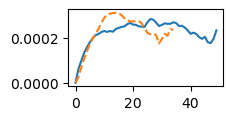

In [182]:

fig, ax = subplots(figsize=(2,1))

ax.plot(M[:,1],"-")
#ax2 = ax.twinx()
ax.plot(2M_data[:,1],"--")
#ax.set_ylim([0,2])
fig

# All lineage

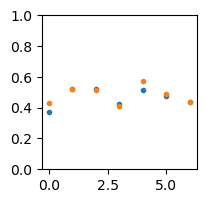

In [189]:
fig,ax = subplots(figsize=(2,2))
ax.plot([msd_lineage_ratio_avg(df,:matern32_flucs_x,40) for df in preds],".")
ax.plot([msd_lineage_avg_ratio(df,:matern32_flucs_x,40) for df in preds],".")

ax.set_ylim([0,1])
fig

# Misc

In [39]:


ens = EnsembleProblem(prob)
sol = solve(ensembleprob, SOSRI(), saveat = 0.1, trajectories = 10_000)
truemean = mean(sol, dims = 3)[:, :]
truevar = var(sol, dims = 3)[:, :]

UndefVarError: UndefVarError: `ensembleprob` not defined